In [53]:
# -*- coding: utf-8 -*-
"""
Last Updated on Sun May  1 10:01:25 2021

@author: Ioannis Pastellas
"""

global n_layers, length
n_layers = 5                 # p value


In [54]:

def objective_optimization(G,params):
    prms = []
    for i in params[0]:
        prms.append(i)
    for i in params[1]:
        prms.append(i)
    print(prms)
    # initialize and set optimizer: 
    opt = COBYLA(maxiter=40)
    
    ret = opt.optimize(num_vars = 2*n_layers, objective_function = objective, initial_point= prms)
    return ret

In [55]:
import qiskit
qiskit.__qiskit_version__


from qiskit import Aer, execute
from qiskit.aqua.components.initial_states import Custom
import TSP
from TSP import *


# useful additional packages 

#import math tools
import numpy as np

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter


# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP,ADAM,P_BFGS
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from numpy import float64
from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram
#from qiskit.optimization.algorithms import CobylaOptimizer

from qiskit.aqua.operators.evolutions import Trotter,Suzuki, EvolvedOp,MatrixEvolution, PauliTrotterEvolution
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.operators import OperatorBase,PrimitiveOp
from qiskit.aqua.operators.list_ops import SummedOp
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua import aqua_globals
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.optimization import QuadraticProgram
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from qiskit.optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer
#IBMQ.load_account() # Load account from disk
#IBMQ.providers()    # List all available providers

from qiskit.optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer

from qiskit.optimization.applications.ising.docplex import *
from qiskit.aqua.components.initial_states import Custom

# IBMQ.stored_account()

In [56]:


NUM_SHOTS = 2048
A = 50000
# Compute the value of the cost function MaxCut
def cost_function_C(x, weights, G):
    E = G.edges()
    V = G.nodes()
    
    if (len(x) != len(weights)):
        return np.nan;
    C = 0;
                
    for i in range(len(weights)):
          C = C + weights[i] * x[i]
         
          
        
    return C;

In [57]:

def solution(params):
    print(params)
    
    (H,pos,feasible)=construct_constraint_Hamiltonian(length,G)
    circ = QuantumCircuit(length)
    feas = feasible[0]
    for j in range(len(feas)):
     if feas[j] == 1:
        circ.x(j)


    initial = Custom(length,circuit= circ)

    op = PrimitiveOp(H)

    hermitians = Hermitians(H)
    print(len(hermitians))
    
    herm_op = []
    for herm in hermitians:
      herm_op.append( PrimitiveOp(herm))

    H_sum = SummedOp(herm_op)

    aqua_globals.random_seed = 10598
    quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'),
                                   seed_simulator=aqua_globals.random_seed,
                                   seed_transpiler=aqua_globals.random_seed)
    
    # it create a qaoa instance with the mixer Hamiltonian the Cost Hamiltonian in Pauli Z representation and initial state
    qaoa_mes = QAOA(quantum_instance=quantum_instance,initial_state= initial,operator = qubitOp,mixer = op,p=n_layers, initial_point=gammabeta)
    #circuit = qaoa_mes.construct_circuit([0.,0.])
    circuit = qaoa_mes.construct_circuit(params)
    
    reg = ClassicalRegister(length)
    circuit[0].add_register(reg)
    circuit[0].measure(range(length),range(length))
    
   
    return circuit[0]


    

def Hermitians(H):
    herm = []
    
    for i in range(2**length):
       for j in range(i+1, 2**length):
           
           if (H[i][j] == 1):
               Hm = [[0 for x in range(2**length)] for y in range(2**length)]
               Hm[i][j] = 1
               Hm[j][i] = 1
               herm.append(Hm)
    return herm 

In [58]:

# Calculation of the Expectation Cost Function
def objective(params):
    print(params)
    
    
    (H,pos,feasible)=construct_constraint_Hamiltonian(length,G)
    
    circ = QuantumCircuit(length)
    feas = feasible[0]
    for j in range(len(feas)):
     if feas[j] == 1:
        circ.x(j)


    initial = Custom(length,circuit= circ)

    op = PrimitiveOp(H)

    hermitians = Hermitians(H)
    
    
    herm_op = []
    for herm in hermitians:
      herm_op.append( PrimitiveOp(herm))

    H_sum = SummedOp(herm_op)

    aqua_globals.random_seed = 10598
    quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'),
                                   seed_simulator=aqua_globals.random_seed,
                                   seed_transpiler=aqua_globals.random_seed)
    qaoa_mes = QAOA(quantum_instance=quantum_instance,initial_state= initial,operator = qubitOp,mixer = op,p=n_layers ) #initial_point=gammabeta
    #circuit = qaoa_mes.construct_circuit([0.,0.])
    circuit = qaoa_mes.construct_circuit(params)
    
    # Add measurements components
    reg = ClassicalRegister(length)
    circuit[0].add_register(reg)
    circuit[0].measure(range(length),range(length))
    
    
    #circuit = parametrized_circuit(params)
   
    
    # Execution of circuit(simulation since we optimizing the parameters)
    backend      = Aer.get_backend("qasm_simulator")
    shots        = 2048

    simulate     = execute(circuit[0], backend=backend, shots=shots)
    QAOA_results = simulate.result()

    #plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)
  
    val = 0
    # Evaluate the data from the simulator
    counts = QAOA_results.get_counts()

    expectedCost       = 0
    maxCost       = [0,0]
    hist        = {}
    
    '''for k in range(length):
      hist[str(k)] = hist.get(str(k),0)'''

    for sample in list(counts.keys()):
     
     # use sampled bit string x to compute C(x)
     x2  = [int(num) for num in list(sample)]
     tmp_eng   = cost_function_C(x2,weights,G)
    
     # compute the expectation value and energy distribution
     expectedCost      = expectedCost     + counts[sample]*tmp_eng
     
    
     
    

    return expectedCost/shots;         
    

In [59]:

def read_graph(n):
    f = open("graph.txt", "r")
    lines = f.readlines()
    adje = [[0 for i in range(n)] for j in range(n)]
    for line in lines:
        a = [float(x) for x in line.split()]
        if a[0] > a[1]:
            temp = a[0]
            a[0] = a[1]
            a[1] = temp
        adje[int(a[0])][int(a[1])] = a[2]
        adje[int(a[1])][int(a[0])] = a[2]
    
    for i in range(n):
      for j in range(n):
         if (adje[i][j] == 0  ):
             adje[i][j] = 0 #attention
    #sorted(E,key=lambda tup: tup[0])
    return adje

In [60]:


pauli_z = [[1, 0], [0, -1]]
print(pauli_z)

pauli_x = [[0, 1], [1, 0]]
pauli_y1 =[]




params = 0.01 * np.random.rand(2,n_layers)#[[0.1],[0.1]]



# Generating the butterfly graph with 5 nodes 
n     = 4
V     = np.arange(0,n,1)
E     =read_edges()

global G 
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

E = G.edges()
global x
x = [0] * int(( len(G.nodes)*(len(G.nodes)-1)/2))
z = 0;
for i in range(len(V)):
   for j in range(i+1,len(V)):
      if (i,j) in E :
         x[z] = 1
      z = z + 1
      

global weights
weights = generate_weight_vector(G)

length = (int) (n*(n-1)/2)    # the number of qubits



(H,pos,feasible)=construct_constraint_Hamiltonian(length,G)  # return mixer Hamiltonian, and one feasible solution

op_H = Operator(H)


weights = generate_weight_vector(G)
gammabeta = [0.50 for i in range(2*n_layers)]




[[1, 0], [0, -1]]


In [61]:
mdl = Model(name='tsp-edges')
x2 = {i: mdl.binary_var() for i in range(length) } #name='x_{0}_{1}'.format(i)

# Object function
tsp_func = mdl.sum(weights[i] * x2[i]  for i in range(length))
mdl.minimize(tsp_func)

# Call the method to convert the model into Ising Hamiltonian.
qubitOp, offset = get_operator(mdl)

In [62]:
import time
time1 =(time.time())
ret = objective_optimization(G,params)         # returns the optimal parameters
time2 =(time.time())

[0.005714568326164996, 0.0034810654829215814, 0.006406771501519009, 0.007424628493171062, 0.0002499260022245242, 0.002500152821812942, 0.005003140177601039, 0.0008247958578108095, 0.0072612974161082346, 0.008110928908493287]
[0.00571457 0.00348107 0.00640677 0.00742463 0.00024993 0.00250015
 0.00500314 0.0008248  0.0072613  0.00811093]
[1.00571457e+00 3.48106548e-03 6.40677150e-03 7.42462849e-03
 2.49926002e-04 2.50015282e-03 5.00314018e-03 8.24795858e-04
 7.26129742e-03 8.11092891e-03]
[1.00571457e+00 1.00348107e+00 6.40677150e-03 7.42462849e-03
 2.49926002e-04 2.50015282e-03 5.00314018e-03 8.24795858e-04
 7.26129742e-03 8.11092891e-03]
[1.00571457e+00 1.00348107e+00 1.00640677e+00 7.42462849e-03
 2.49926002e-04 2.50015282e-03 5.00314018e-03 8.24795858e-04
 7.26129742e-03 8.11092891e-03]
[1.00571457e+00 1.00348107e+00 6.40677150e-03 1.00742463e+00
 2.49926002e-04 2.50015282e-03 5.00314018e-03 8.24795858e-04
 7.26129742e-03 8.11092891e-03]
[1.00571457e+00 1.00348107e+00 6.40677150e-03 

[ 0.85298058  1.0862532  -0.05758304 -0.05317264  0.45224634  0.92812254
  1.01565904 -0.0189443  -0.00138318 -0.03241689]
2


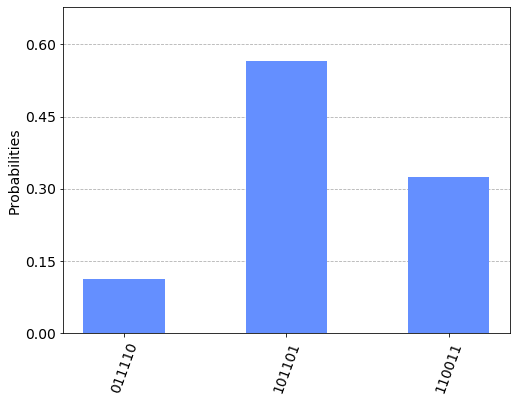

In [63]:
 # Execution of circuit(either simulation or on real quantum machines)
backend      = Aer.get_backend("qasm_simulator")
shots        = 2048

simulate     = execute(solution(ret[0]), backend=backend, shots=shots)
QAOA_results = simulate.result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)
  
    
   

In [64]:
print((time2-time1))

7.766441822052002
